In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [3]:
setting = 8
setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % setting))

In [4]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = [100,200,300,400,500,600,700,800,900,1000]
margins_to_sample = [200, 500]
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Load pre-computed svm classifiers

In [5]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':setting})
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('No classifier for %s is found.\n' % structure)

No classifier for sp5 is found.
No classifier for outerContour is found.


In [6]:
if setting in [1,2,3,4,5,6,7]:
    margin = 500

# Generate Test Dataset

In [10]:
# Extract test features

test_addresses = defaultdict(list)

labels_found = set([])

for stack in all_annotated_nissl_stacks:
# for stack in ['MD635']:
    annotation_grid_indices_fn = os.path.join(ANNOTATION_ROOTDIR, stack, stack + '_annotation_grid_indices.h5')
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels_found = labels_found | labels_this_stack
    
    test_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, 
                                                  num_samples_per_landmark=100)
    
    for label, addresses in test_addresses_sec_idx.iteritems():
        test_addresses[label] += [(stack, ) + addr for addr in addresses]
        
test_addresses.default_factory = None

Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.


In [53]:
structures_found = sorted(set([convert_to_original_name(l) for l in labels_found]) - {'noclass'})

In [11]:
test_features = apply_function_to_dict(addresses_to_features, test_addresses)

('MD585', 83)
('MD585', 84)
('MD585', 85)
('MD585', 86)
('MD585', 87)
('MD585', 88)
('MD585', 89)
('MD585', 90)
('MD585', 91)
('MD585', 92)
('MD585', 93)
('MD585', 94)
('MD585', 95)
('MD585', 96)
('MD585', 97)
('MD585', 98)
('MD585', 99)
('MD585', 100)
('MD585', 101)
('MD585', 102)
('MD585', 103)
('MD585', 104)
('MD585', 105)
('MD585', 106)
('MD585', 107)
('MD585', 108)
('MD585', 109)
('MD585', 110)
('MD585', 111)
('MD585', 112)
('MD585', 113)
('MD585', 114)
('MD585', 115)
('MD585', 116)
('MD585', 117)
('MD585', 119)
('MD585', 120)
('MD585', 121)
('MD585', 122)
('MD585', 123)
('MD585', 124)
('MD585', 125)
('MD585', 126)
('MD585', 127)


Patch in annotation but not in mask: MD585 127 MD585-N24-2015.08.19-15.29.12_MD585_1_0070 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @48


('MD585', 128)
('MD585', 129)


Patch in annotation but not in mask: MD585 129 MD585-N24-2015.08.19-15.29.12_MD585_2_0071 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @19201


('MD585', 130)
('MD585', 131)
('MD585', 132)
('MD585', 133)
('MD585', 134)
('MD585', 135)
('MD585', 136)
('MD585', 137)
('MD585', 138)
('MD585', 139)
('MD585', 140)


Patch in annotation but not in mask: MD585 140 MD585-IHC26-2015.08.19-13.23.15_MD585_1_0076 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @23421


('MD585', 141)
('MD585', 142)
('MD585', 143)


Patch in annotation but not in mask: MD585 143 MD585-N26-2015.08.19-15.37.53_MD585_3_0078 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @116


('MD585', 144)


Patch in annotation but not in mask: MD585 144 MD585-IHC26-2015.08.19-13.23.15_MD585_3_0078 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @177


('MD585', 145)
('MD585', 146)
('MD585', 147)
('MD585', 148)
('MD585', 149)
('MD585', 150)
('MD585', 151)


Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @51018
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @54407
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @54618
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @52503
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @50599


('MD585', 152)
('MD585', 153)
('MD585', 154)
('MD585', 155)


Patch in annotation but not in mask: MD585 155 MD585-N28-2015.08.19-15.47.09_MD585_3_0084 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @10339


('MD585', 156)
('MD585', 157)
('MD585', 158)
('MD585', 159)
('MD585', 160)
('MD585', 161)


Patch in annotation but not in mask: MD585 161 MD585-N29-2015.08.19-15.51.55_MD585_3_0087 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @10339


('MD585', 162)
('MD585', 163)
('MD585', 164)
('MD585', 165)


Patch in annotation but not in mask: MD585 165 MD585-N30-2015.08.19-15.56.52_MD585_2_0089 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @13293


('MD585', 166)
('MD585', 167)
('MD585', 168)
('MD585', 169)
('MD585', 170)
('MD585', 171)
('MD585', 172)
('MD585', 173)
('MD585', 174)
('MD585', 175)
('MD585', 176)
('MD585', 177)
('MD585', 178)
('MD585', 179)
('MD585', 180)
('MD585', 181)


Patch in annotation but not in mask: MD585 181 MD585-N33-2015.07.16-21.37.52_MD585_1_0097 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @112


('MD585', 182)
('MD585', 183)
('MD585', 184)


Patch in annotation but not in mask: MD585 184 MD585-IHC33-2015.07.16-16.33.07_MD585_2_0098 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @153


('MD585', 185)
('MD585', 186)
('MD585', 187)
('MD585', 188)
('MD585', 189)
('MD585', 190)
('MD585', 191)
('MD585', 192)
('MD585', 193)
('MD585', 194)
('MD585', 195)
('MD585', 196)
('MD585', 197)
('MD585', 198)
('MD585', 199)
('MD585', 200)
('MD585', 201)
('MD585', 202)
('MD585', 203)
('MD585', 204)


Patch in annotation but not in mask: MD585 204 MD585-IHC36-2015.08.19-13.58.57_MD585_3_0108 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @16880


('MD585', 205)
('MD585', 206)
('MD585', 207)
('MD585', 208)
('MD585', 209)
('MD585', 210)
('MD585', 211)
('MD585', 212)
('MD585', 213)
('MD585', 214)
('MD585', 215)
('MD585', 216)
('MD585', 217)
('MD585', 218)
('MD585', 219)


Patch in annotation but not in mask: MD585 219 MD585-N39-2015.07.16-22.09.19_MD585_2_0116 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @5908


('MD585', 220)


Patch in annotation but not in mask: MD585 220 MD585-IHC39-2015.08.19-14.10.09_MD585_2_0116 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @8651


('MD585', 221)
('MD585', 222)
('MD585', 223)
('MD585', 224)
('MD585', 225)
('MD585', 226)
('MD585', 227)
('MD585', 228)


Patch in annotation but not in mask: MD585 228 MD585-IHC40-2015.08.19-14.15.44_MD585_3_0120 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @2954


('MD585', 229)


Patch in annotation but not in mask: MD585 229 MD585-N41-2015.07.16-22.19.30_MD585_1_0121 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @1


('MD585', 230)


Patch in annotation but not in mask: MD585 230 MD585-IHC41-2015.08.19-14.21.09_MD585_1_0121 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @113


('MD585', 231)
('MD585', 232)
('MD585', 233)
('MD585', 234)
('MD585', 235)
('MD585', 236)
('MD585', 237)
('MD585', 238)
('MD585', 239)
('MD585', 240)
('MD585', 241)
('MD585', 242)
('MD585', 243)
('MD585', 244)
('MD585', 245)
('MD585', 246)
('MD585', 247)
('MD585', 248)
('MD585', 249)
('MD585', 250)
('MD585', 251)
('MD585', 252)
('MD585', 253)
('MD585', 254)
('MD585', 255)
('MD585', 256)
('MD585', 257)


Patch in annotation but not in mask: MD585 257 MD585-N45-2015.07.16-22.40.26_MD585_3_0135 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @15403


('MD585', 258)
('MD585', 259)
('MD585', 260)
('MD585', 261)
('MD585', 262)
('MD585', 263)
('MD585', 264)
('MD585', 265)
('MD585', 266)
('MD585', 267)
('MD585', 269)
('MD585', 270)
('MD585', 271)
('MD585', 272)
('MD585', 273)


Patch in annotation but not in mask: MD585 273 MD585-N48-2015.07.16-22.56.02_MD585_2_0143 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @173


('MD585', 274)
('MD585', 275)
('MD585', 276)
('MD585', 277)
('MD585', 278)
('MD585', 279)
('MD585', 280)
('MD585', 281)
('MD585', 282)
('MD585', 283)
('MD585', 284)
('MD585', 285)
('MD585', 286)
('MD585', 287)


Patch in annotation but not in mask: MD585 287 MD585-N50-2015.07.16-23.05.49_MD585_3_0150 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @1899


('MD585', 288)
('MD585', 289)


Patch in annotation but not in mask: MD585 289 MD585-N51-2015.07.16-23.10.35_MD585_1_0151 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @18990


('MD585', 290)
('MD585', 291)
('MD585', 292)
('MD585', 293)
('MD585', 294)
('MD585', 295)
('MD585', 296)
('MD585', 297)
('MD585', 298)
('MD585', 300)
('MD585', 301)
('MD585', 302)
('MD585', 303)


Patch in annotation but not in mask: MD585 303 MD585-N53-2015.08.19-16.16.47_MD585_2_0158 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @19834


('MD585', 304)
('MD585', 305)
('MD585', 306)
('MD585', 307)
('MD585', 308)
('MD585', 309)
('MD585', 310)
('MD585', 311)
('MD585', 312)


Patch in annotation but not in mask: MD585 312 MD585-IHC54-2015.08.19-15.16.31_MD585_3_0162 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @633


('MD585', 313)
('MD585', 314)
('MD585', 315)


Patch in annotation but not in mask: MD585 315 MD585-N55-2015.08.19-16.25.32_MD585_2_0164 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @62


('MD585', 316)
('MD585', 317)
('MD585', 318)
('MD585', 319)
('MD585', 320)
('MD585', 321)
('MD585', 322)
('MD585', 323)
('MD585', 324)
('MD585', 325)
('MD585', 326)
('MD585', 327)
('MD585', 328)
('MD585', 329)
('MD585', 330)
('MD585', 331)
('MD585', 332)
('MD585', 333)
('MD585', 334)
('MD585', 335)
('MD585', 336)
('MD585', 337)
('MD585', 338)
('MD585', 339)
('MD585', 340)
('MD585', 341)
('MD585', 342)
('MD585', 343)
('MD585', 344)
('MD585', 345)
('MD585', 346)
('MD585', 347)
('MD585', 348)
('MD585', 349)
('MD585', 350)
('MD589', 94)
('MD589', 95)
('MD589', 96)
('MD589', 97)
('MD589', 98)
('MD589', 99)
('MD589', 100)
('MD589', 101)
('MD589', 102)
('MD589', 103)
('MD589', 104)
('MD589', 105)
('MD589', 106)
('MD589', 107)
('MD589', 108)
('MD589', 109)
('MD589', 110)
('MD589', 111)
('MD589', 112)
('MD589', 113)
('MD589', 114)
('MD589', 115)
('MD589', 116)
('MD589', 117)
('MD589', 119)


Patch in annotation but not in mask: MD589 119 MD589-IHC21-2015.07.30-22.40.00_MD589_1_0061 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @18


('MD589', 120)
('MD589', 121)
('MD589', 122)
('MD589', 123)
('MD589', 124)
('MD589', 125)
('MD589', 126)
('MD589', 127)


Patch in annotation but not in mask: MD589 127 MD589-IHC22-2015.07.30-22.44.25_MD589_2_0065 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @2730


('MD589', 128)
('MD589', 129)
('MD589', 130)
('MD589', 131)
('MD589', 132)
('MD589', 133)
('MD589', 134)
('MD589', 135)
('MD589', 136)
('MD589', 137)
('MD589', 138)


Patch in annotation but not in mask: MD589 138 MD589-N24-2015.07.30-17.35.51_MD589_2_0071 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @132


('MD589', 139)
('MD589', 140)
('MD589', 141)
('MD589', 142)
('MD589', 143)
('MD589', 144)
('MD589', 145)
('MD589', 146)
('MD589', 147)
('MD589', 148)
('MD589', 149)
('MD589', 150)
('MD589', 151)
('MD589', 152)
('MD589', 153)
('MD589', 154)
('MD589', 155)
('MD589', 156)


Patch in annotation but not in mask: MD589 156 MD589-N27-2015.07.30-17.49.06_MD589_2_0080 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @132


('MD589', 157)
('MD589', 158)
('MD589', 159)
('MD589', 160)
('MD589', 161)
('MD589', 162)
('MD589', 163)
('MD589', 164)


Patch in annotation but not in mask: MD589 164 MD589-N28-2015.07.30-17.53.43_MD589_3_0084 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @15120


('MD589', 165)
('MD589', 166)
('MD589', 167)
('MD589', 168)
('MD589', 169)
('MD589', 170)
('MD589', 171)
('MD589', 172)


Patch in annotation but not in mask: MD589 172 MD589-N30-2015.07.30-18.03.11_MD589_1_0088 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @10


('MD589', 173)


Patch in annotation but not in mask: MD589 173 MD589-IHC30-2015.07.30-23.20.46_MD589_1_0088 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @64


('MD589', 174)
('MD589', 175)
('MD589', 176)


Patch in annotation but not in mask: MD589 176 MD589-N30-2015.07.30-18.03.11_MD589_3_0090 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @94


('MD589', 177)
('MD589', 178)
('MD589', 179)
('MD589', 180)
('MD589', 181)
('MD589', 182)
('MD589', 183)
('MD589', 184)
('MD589', 185)
('MD589', 186)
('MD589', 187)
('MD589', 188)
('MD589', 189)
('MD589', 190)
('MD589', 191)
('MD589', 192)
('MD589', 193)
('MD589', 194)
('MD589', 195)
('MD589', 196)
('MD589', 197)
('MD589', 198)
('MD589', 199)
('MD589', 200)
('MD589', 201)
('MD589', 202)
('MD589', 203)
('MD589', 204)
('MD589', 205)
('MD589', 206)
('MD589', 207)
('MD589', 208)
('MD589', 209)
('MD589', 210)
('MD589', 211)
('MD589', 212)
('MD589', 213)


Patch in annotation but not in mask: MD589 213 MD589-IHC39-2015.07.30-23.58.27_MD589_2_0116 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @131


('MD589', 214)
('MD589', 215)


Patch in annotation but not in mask: MD589 215 MD589-IHC40-2015.07.31-00.02.21_MD589_1_0118 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @6930


('MD589', 216)
('MD589', 217)
('MD589', 218)
('MD589', 219)
('MD589', 220)
('MD589', 222)
('MD589', 223)


Patch in annotation but not in mask: MD589 223 MD589-IHC42-2015.07.31-00.10.45_MD589_1_0124 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @46


('MD589', 224)
('MD589', 225)
('MD589', 226)
('MD589', 227)
('MD589', 228)
('MD589', 229)
('MD589', 230)
('MD589', 231)
('MD589', 232)
('MD589', 233)
('MD589', 234)
('MD589', 235)
('MD589', 236)


Patch in annotation but not in mask: MD589 236 MD589-N45-2015.07.30-19.04.31_MD589_2_0134 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @5040


('MD589', 237)


Patch in annotation but not in mask: MD589 237 MD589-IHC45-2015.07.31-00.23.02_MD589_2_0134 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @140


('MD589', 238)
('MD589', 239)
('MD589', 240)
('MD589', 241)
('MD589', 242)
('MD589', 243)
('MD589', 244)
('MD589', 245)


Patch in annotation but not in mask: MD589 245 MD589-IHC47-2015.07.31-00.31.08_MD589_2_0140 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @630


('MD589', 246)
('MD589', 247)
('MD589', 248)
('MD589', 249)
('MD589', 250)
('MD589', 251)
('MD589', 252)
('MD589', 253)
('MD589', 254)
('MD589', 255)
('MD589', 256)
('MD589', 257)
('MD589', 258)
('MD589', 259)
('MD589', 260)
('MD589', 261)
('MD589', 262)
('MD589', 263)
('MD589', 264)
('MD589', 265)
('MD589', 266)
('MD589', 267)
('MD589', 268)
('MD589', 269)
('MD589', 270)
('MD589', 271)
('MD589', 272)
('MD589', 273)
('MD589', 274)
('MD589', 275)
('MD589', 276)
('MD589', 277)
('MD589', 278)


Patch in annotation but not in mask: MD589 278 MD589-N54-2015.07.30-19.44.32_MD589_2_0161 alignedTo MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091 @80


('MD589', 279)
('MD589', 280)
('MD589', 281)
('MD589', 282)
('MD589', 283)
('MD589', 284)
('MD589', 285)
('MD589', 286)
('MD589', 287)
('MD589', 288)
('MD589', 289)
('MD589', 290)
('MD589', 291)
('MD589', 292)
('MD589', 293)
('MD589', 294)
('MD589', 295)
('MD589', 296)
('MD589', 297)
('MD589', 298)
('MD589', 299)
('MD589', 301)
('MD589', 302)
('MD589', 303)
('MD589', 304)
('MD589', 305)
('MD589', 306)
('MD589', 307)
('MD589', 308)
('MD589', 309)
('MD589', 310)
('MD589', 311)
('MD589', 312)
('MD589', 313)
('MD589', 314)
('MD589', 315)
('MD589', 316)
('MD589', 317)
('MD589', 318)
('MD589', 319)
('MD589', 320)
('MD589', 321)
('MD589', 322)
('MD589', 323)
('MD589', 325)
('MD589', 326)
('MD589', 327)
('MD589', 328)
('MD589', 329)
('MD589', 330)
('MD589', 331)
('MD589', 332)
('MD589', 333)
('MD589', 334)
('MD589', 335)
('MD589', 336)
('MD589', 337)
('MD589', 338)
('MD589', 339)
('MD589', 340)
('MD589', 341)
('MD589', 342)
('MD589', 343)
('MD589', 344)
('MD589', 345)
('MD589', 346)
('MD589', 

Patch in annotation but not in mask: MD594 106 MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @171


('MD594', 107)
('MD594', 108)
('MD594', 109)
('MD594', 110)
('MD594', 111)
('MD594', 112)
('MD594', 113)
('MD594', 114)
('MD594', 115)
('MD594', 116)
('MD594', 117)
('MD594', 118)
('MD594', 119)
('MD594', 120)
('MD594', 121)
('MD594', 122)
('MD594', 123)
('MD594', 124)
('MD594', 125)
('MD594', 126)
('MD594', 127)
('MD594', 128)
('MD594', 129)
('MD594', 130)
('MD594', 132)
('MD594', 133)
('MD594', 134)
('MD594', 135)
('MD594', 136)
('MD594', 137)
('MD594', 138)
('MD594', 139)
('MD594', 140)
('MD594', 141)
('MD594', 142)
('MD594', 143)
('MD594', 144)
('MD594', 145)
('MD594', 146)


Patch in annotation but not in mask: MD594 146 MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @140


('MD594', 147)
('MD594', 148)


Patch in annotation but not in mask: MD594 148 MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @26910


('MD594', 149)
('MD594', 150)
('MD594', 151)
('MD594', 152)


Patch in annotation but not in mask: MD594 152 MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @135


('MD594', 153)
('MD594', 154)
('MD594', 155)
('MD594', 156)
('MD594', 157)
('MD594', 158)
('MD594', 159)
('MD594', 160)
('MD594', 161)
('MD594', 162)
('MD594', 163)
('MD594', 164)
('MD594', 165)
('MD594', 166)
('MD594', 167)
('MD594', 168)


Patch in annotation but not in mask: MD594 168 MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @10920


('MD594', 169)
('MD594', 170)
('MD594', 171)
('MD594', 172)
('MD594', 173)
('MD594', 174)


Patch in annotation but not in mask: MD594 174 MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @29250


('MD594', 175)
('MD594', 176)
('MD594', 177)
('MD594', 178)
('MD594', 179)
('MD594', 180)
('MD594', 181)
('MD594', 182)
('MD594', 183)
('MD594', 184)
('MD594', 185)
('MD594', 186)
('MD594', 188)
('MD594', 189)
('MD594', 190)
('MD594', 191)
('MD594', 192)


Patch in annotation but not in mask: MD594 192 MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @24375


('MD594', 194)
('MD594', 195)
('MD594', 196)
('MD594', 197)
('MD594', 198)
('MD594', 199)
('MD594', 200)
('MD594', 201)
('MD594', 202)
('MD594', 203)
('MD594', 204)
('MD594', 205)
('MD594', 206)
('MD594', 207)
('MD594', 208)
('MD594', 209)
('MD594', 210)
('MD594', 211)
('MD594', 212)
('MD594', 213)
('MD594', 214)
('MD594', 215)


Patch in annotation but not in mask: MD594 215 MD594-N46-2015.08.26-23.34.38_MD594_1_0136 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @14430


('MD594', 216)
('MD594', 217)


Patch in annotation but not in mask: MD594 217 MD594-N46-2015.08.26-23.34.38_MD594_2_0137 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @147
Patch in annotation but not in mask: MD594 217 MD594-N46-2015.08.26-23.34.38_MD594_2_0137 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @39


('MD594', 218)
('MD594', 219)
('MD594', 220)
('MD594', 221)
('MD594', 222)
('MD594', 223)
('MD594', 224)
('MD594', 225)
('MD594', 226)
('MD594', 227)
('MD594', 228)


Patch in annotation but not in mask: MD594 228 MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @83


('MD594', 229)
('MD594', 230)
('MD594', 231)
('MD594', 232)


Patch in annotation but not in mask: MD594 232 MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @159


('MD594', 233)
('MD594', 234)
('MD594', 235)


Patch in annotation but not in mask: MD594 235 MD594-N51-2015.08.26-23.54.38_MD594_1_0151 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @30225


('MD594', 236)
('MD594', 237)
('MD594', 239)
('MD594', 240)
('MD594', 241)
('MD594', 242)
('MD594', 243)
('MD594', 244)
('MD594', 245)


Patch in annotation but not in mask: MD594 245 MD594-N54-2015.08.27-00.02.48_MD594_1_0160 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @92


('MD594', 246)
('MD594', 247)
('MD594', 248)
('MD594', 249)
('MD594', 250)
('MD594', 251)
('MD594', 252)
('MD594', 253)
('MD594', 254)
('MD594', 255)
('MD594', 256)
('MD594', 257)
('MD594', 258)
('MD594', 259)
('MD594', 260)
('MD594', 262)


Patch in annotation but not in mask: MD594 262 MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @17940


('MD594', 263)


Patch in annotation but not in mask: MD594 263 MD594-N58-2015.08.27-00.19.01_MD594_2_0173 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @39


('MD594', 264)
('MD594', 265)
('MD594', 266)
('MD594', 267)
('MD594', 268)


Patch in annotation but not in mask: MD594 268 MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @70


('MD594', 269)
('MD594', 270)
('MD594', 271)
('MD594', 272)
('MD594', 273)
('MD594', 274)
('MD594', 275)


Patch in annotation but not in mask: MD594 275 MD594-N61-2015.08.27-00.31.50_MD594_2_0182 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @142
Patch in annotation but not in mask: MD594 275 MD594-N61-2015.08.27-00.31.50_MD594_2_0182 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @177


('MD594', 276)
('MD594', 277)
('MD594', 278)


Patch in annotation but not in mask: MD594 278 MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @166


('MD594', 279)
('MD594', 280)


Patch in annotation but not in mask: MD594 280 MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @42


('MD594', 281)
('MD594', 282)
('MD594', 283)
('MD594', 284)
('MD594', 285)
('MD594', 286)
('MD594', 287)


Patch in annotation but not in mask: MD594 287 MD594-N64-2015.08.27-00.43.47_MD594_2_0191 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @166


('MD594', 288)


Patch in annotation but not in mask: MD594 288 MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @169


('MD594', 289)
('MD594', 290)
('MD594', 291)
('MD594', 292)
('MD594', 293)
('MD594', 294)
('MD594', 295)
('MD594', 296)
('MD594', 297)
('MD594', 298)


Patch in annotation but not in mask: MD594 298 MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @31590


('MD594', 299)
('MD594', 300)
('MD594', 301)
('MD594', 302)
('MD594', 303)
('MD594', 304)
('MD594', 305)
('MD594', 306)
('MD594', 307)
('MD594', 308)
('MD594', 309)
('MD594', 310)
('MD594', 311)
('MD594', 312)
('MD594', 313)
('MD594', 314)
('MD594', 315)
('MD594', 316)
('MD594', 317)


Patch in annotation but not in mask: MD594 317 MD594-N70-2015.08.27-01.10.06_MD594_1_0208 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @128


('MD594', 318)
('MD594', 319)
('MD594', 320)
('MD594', 321)
('MD594', 322)
('MD594', 323)
('MD594', 324)
('MD594', 325)
('MD594', 326)
('MD594', 327)


Patch in annotation but not in mask: MD594 327 MD594-N71-2015.08.27-01.14.30_MD594_3_0213 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @25350


('MD594', 328)
('MD594', 329)
('MD594', 330)
('MD594', 331)
('MD594', 332)
('MD594', 333)
('MD594', 334)
('MD594', 335)
('MD594', 336)
('MD594', 337)
('MD594', 338)
('MD594', 339)
('MD594', 340)
('MD594', 342)
('MD594', 343)
('MD594', 344)
('MD594', 345)
('MD594', 346)
('MD594', 347)
('MD594', 348)
('MD594', 349)
('MD594', 350)


Patch in annotation but not in mask: MD594 350 MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @169


('MD594', 351)
('MD594', 352)
('MD594', 353)
('MD594', 354)
('MD594', 355)
('MD594', 356)
('MD594', 357)


Patch in annotation but not in mask: MD594 357 MD594-N76-2015.08.27-01.35.41_MD594_3_0228 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @163


('MD594', 358)
('MD594', 359)
('MD594', 360)
('MD594', 361)
('MD594', 362)
('MD594', 363)


In [22]:
test_features = {label: np.array([f for f in feats if f is not None]) 
                 for label, feats in test_features.iteritems()}

In [25]:
for label, feats in test_features.iteritems():
    print label, len(feats)

Amb_surround_500_7N 59
12N_surround_500_AP 161
RtTg_surround_200_Tz 3
VCA_surround_200_DC 195
SNC_negative 296
Tz_negative 299
SNC_surround_500_SNR 300
3N_surround_200_noclass 300
SNR_surround_500_SNC 300
SNR_surround_500_PBG 177
5N 300
Sp5I_surround_500_Sp5C 300
SNC_surround_500_noclass 300
Sp5I_surround_500_Sp5O 300
LRt_negative 298
6N_surround_500_7n 225
AP_surround_200_10N 1
DC_surround_200_VCA 208
7n_surround_200_noclass 300
4N_negative 297
12N 300
3N_surround_500_noclass 300
DC_surround_200_VCP 251
6N_negative 295
LC_negative 299
Sp5O 300
SNC_surround_200_SNR 300
LRt_surround_200_Amb 4
Sp5I 300
VCA_surround_500_noclass 300
VCP_surround_200_VCA 300
Sp5C 295
Sp5O_negative 298
3N_surround_500_4N 206
SC_surround_200_noclass 300
Amb_surround_500_LRt 156
Sp5O_surround_200_Sp5I 300
LC_surround_500_noclass 300
SC_surround_500_IC 300
Amb_negative 295
SNC 300
Tz_surround_200_RtTg 2
4N_surround_500_3N 300
DC_surround_500_VCA 300
Pn_surround_200_RtTg 241
10N_surround_200_noclass 300
SNR 300


In [24]:
test_feat_dir = create_if_not_exists(os.path.join(setting_dir, 'test_features'))

# Save test features
for label, feats in test_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(test_feat_dir, label + '.bp'))
    
# Save test addresses
save_pickle(test_addresses, os.path.join(setting_dir, 'test_addresses.pkl'))

# Load Test Features

In [7]:
dataset = 2

In [8]:
# load test addresses
test_addresses = load_pickle(os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))
test_addresses = {l: addrs for l, addrs in test_addresses.iteritems() if l in labels_to_sample}

In [9]:
# Load test features

test_features = {}
for label in labels_to_sample:
    feat_fp = os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_features', label + '.bp')
    if os.path.exists(feat_fp):
        test_features[label] = bp.unpack_ndarray_file(feat_fp)

In [10]:
assert set(test_addresses.keys()) == set(test_features.keys()), \
'Test features and test addresses are not consistent.'

In [11]:
labels_found = test_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

In [12]:
eval_dir = create_if_not_exists(os.path.join(setting_dir, 'eval'))

In [ ]:
# Compute x vs. all negative accuracy

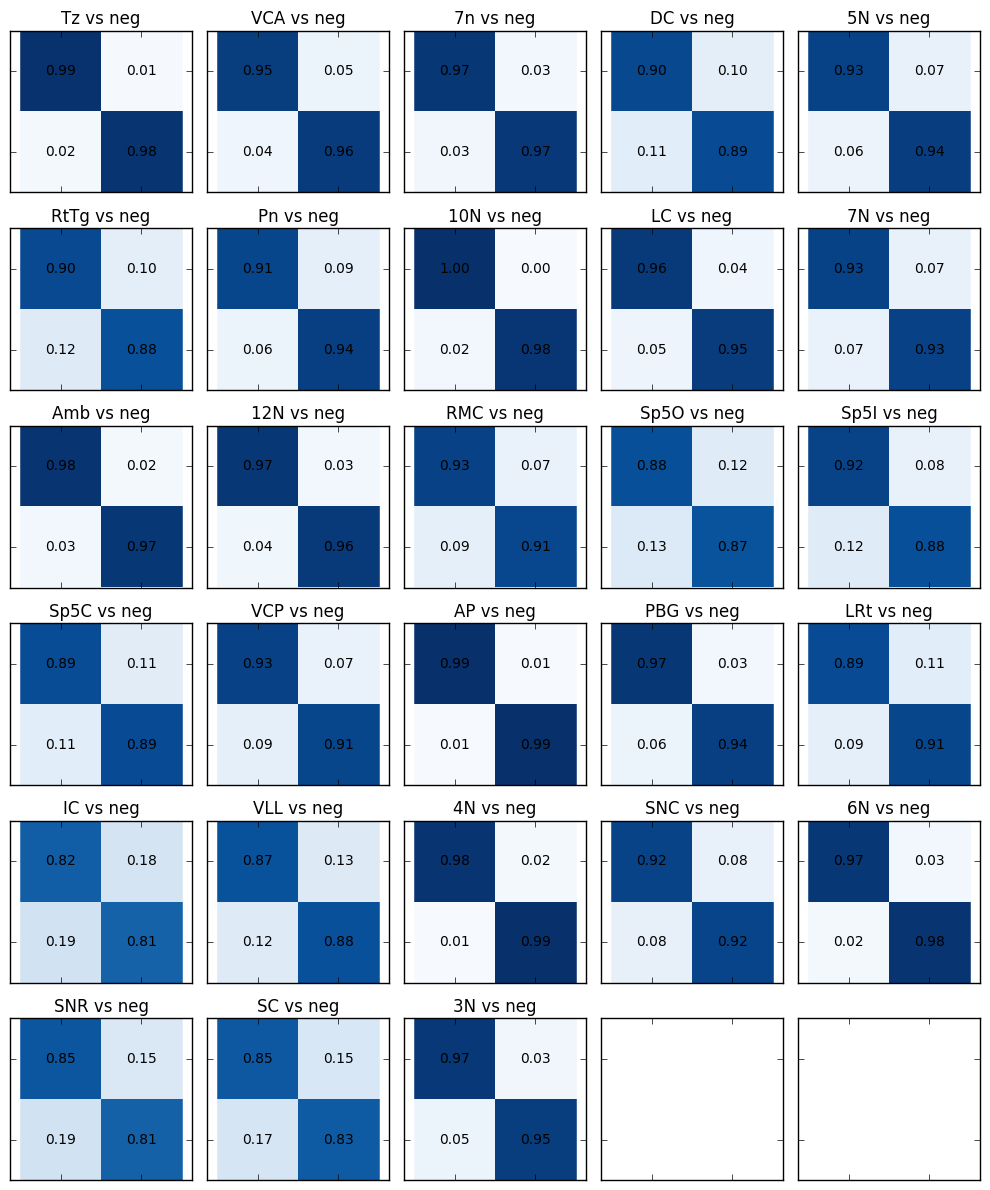

In [13]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features[structure + '_negative']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs neg'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc

plt.tight_layout()

In [14]:
print 'test accuracy:', np.mean(acc_all_structures.values())

test accuracy: 0.927085564482


In [15]:
single_vs_negative_cm_plot_fp = os.path.join(eval_dir, 'single_vs_negative_cm_setting_%d.png' % setting)
fig.savefig(single_vs_negative_cm_plot_fp, bbox_inches='tight')

# Compute x vs. noclass accuracy

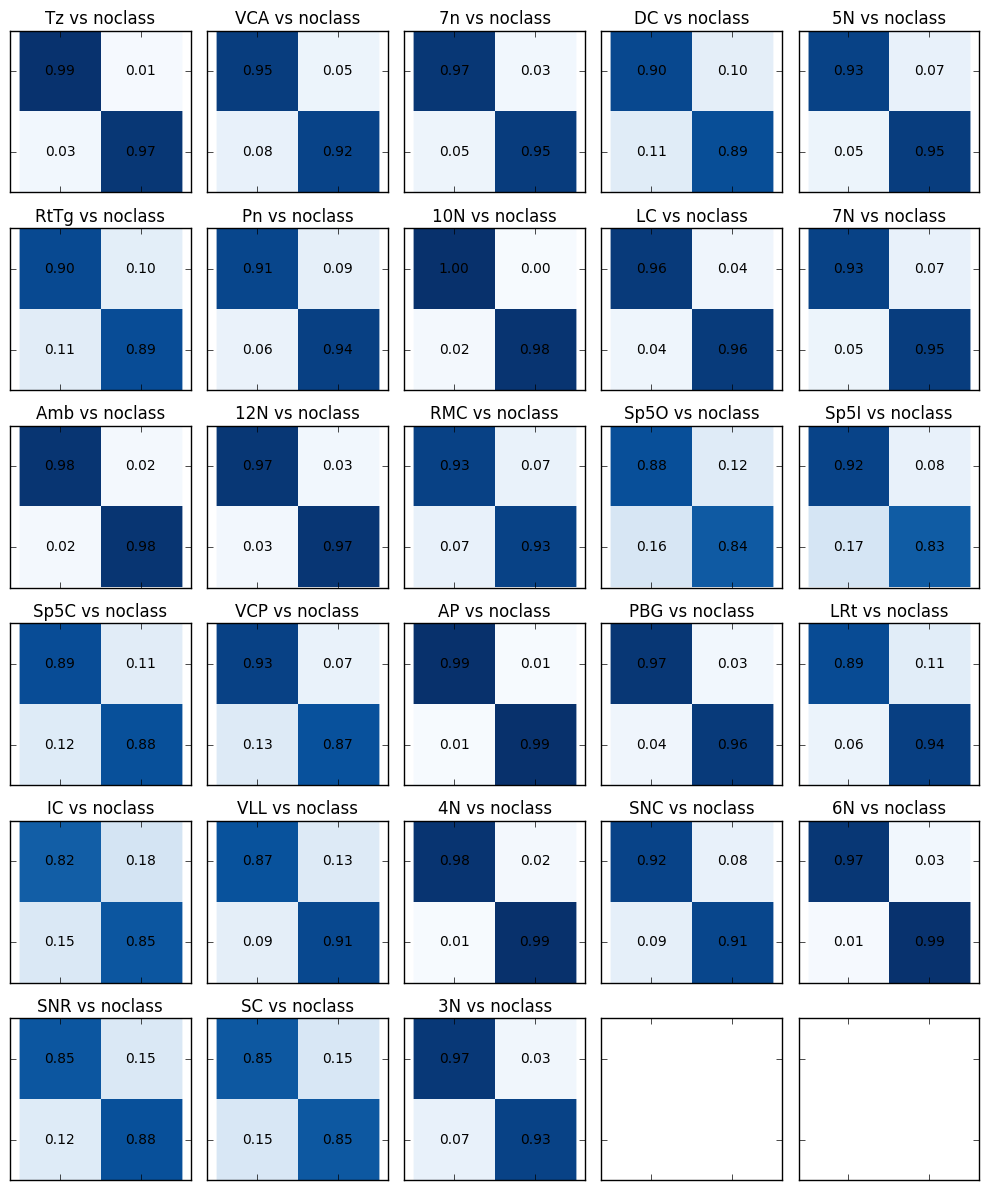

In [16]:
# Compute x vs. noclass accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    features_neg = test_features['noclass']        
    n_neg = len(features_neg)
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s vs noclass'% {'structure':structure},
                          labels=['',''], xlabel='', ylabel='', 
                          axis=axes[i])
    
    
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                 normalize=False)
    acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
    acc_all_structures[label] = acc

plt.tight_layout()

In [17]:
print 'test accuracy:', np.mean(acc_all_structures.values())

test accuracy: 0.928037319592


In [18]:
single_vs_noclass_cm_plot_fp = os.path.join(eval_dir, 'single_vs_noclass_cm_setting_%d.png' % setting)
fig.savefig(single_vs_noclass_cm_plot_fp, bbox_inches='tight')

# Compute surround accuracy (margin = 200)

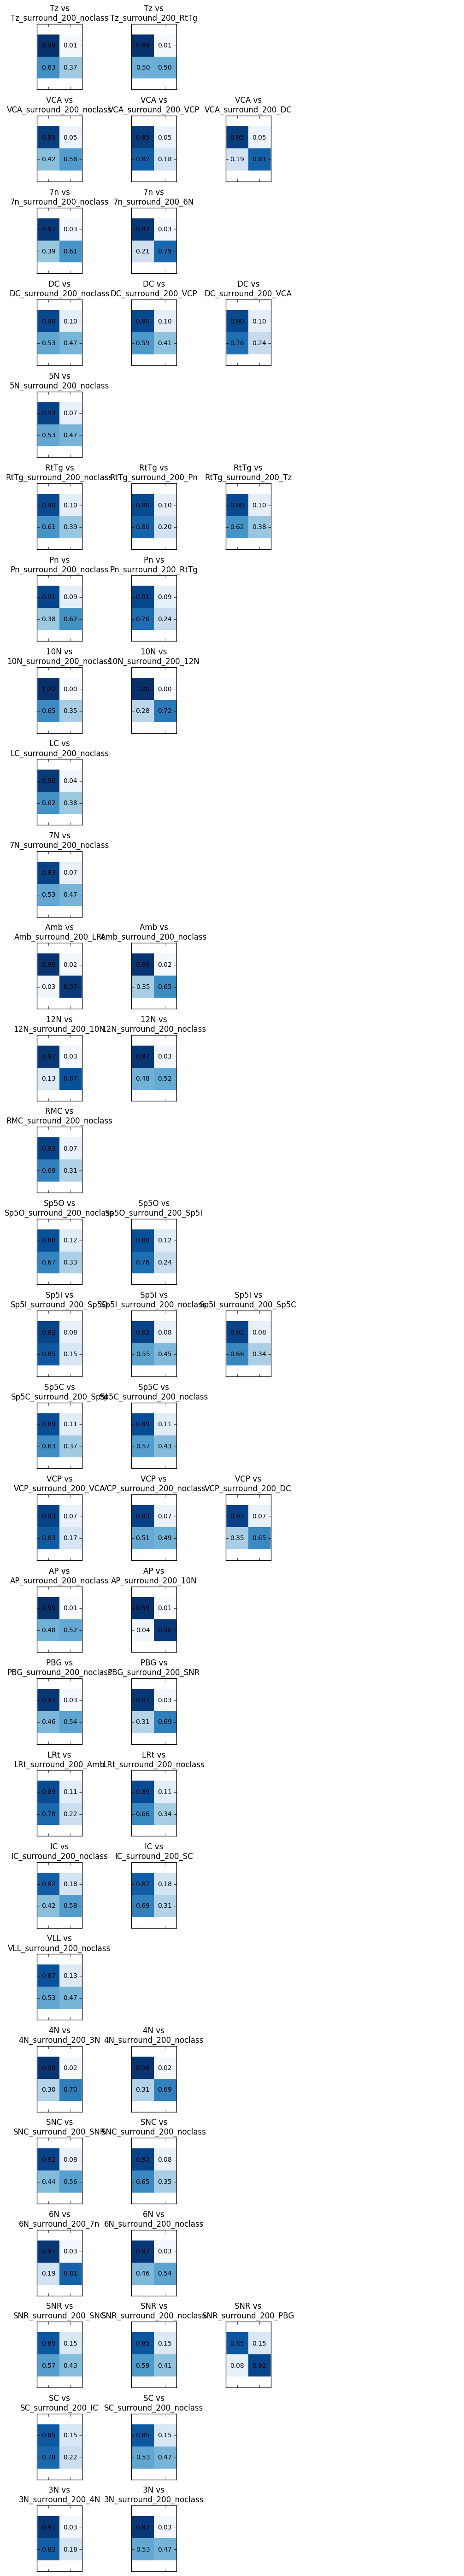

In [19]:
# Compute surround accuracy (margin = 200)

margin = 200
acc_all_pairs = {}

ncols = 5
nrows = len(structures_found)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
# axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = test_features[structure]
    n_pos = len(features_pos)
    
    neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
    [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]

    neg_classes = list(set(neg_classes) & set(labels_found))
    
    for j, neg_class in enumerate(neg_classes):

        features_neg = test_features[neg_class]
        n_neg = len(features_neg)

        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=True)

        plot_confusion_matrix(cm, title='%(structure)s vs\n%(neg_class)s'% {'structure':structure, 'neg_class': neg_class},
                              labels=['',''], xlabel='', ylabel='',
                             axis=axes[i, j])

        cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                     normalize=False)
        acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
        acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc
        
    for j in range(len(neg_classes), ncols):
        axes[i,j].axis('off')

plt.tight_layout()

In [20]:
surround_cm_plot_fp = os.path.join(eval_dir, 'surround_cm_setting_%d.png' % setting)
fig.savefig(surround_cm_plot_fp, bbox_inches='tight')

In [21]:
print np.mean(acc_all_pairs.values())

0.733847371984


In [22]:
sorted(acc_all_pairs.items(), key=lambda (x,y): y)

[('SC vs SC_surround_200_IC', 0.53274323505766807),
 ('Sp5I vs Sp5I_surround_200_Sp5O', 0.53748557172027822),
 ('VCP vs VCP_surround_200_VCA', 0.54996678012675615),
 ('Sp5O vs Sp5O_surround_200_Sp5I', 0.55948289073163004),
 ('VCA vs VCA_surround_200_VCP', 0.56550424345935457),
 ('IC vs IC_surround_200_SC', 0.56810086417128192),
 ('RtTg vs RtTg_surround_200_Pn', 0.5779076286576651),
 ('Sp5O vs Sp5O_surround_200_noclass', 0.60347993405303957),
 ('Pn vs Pn_surround_200_RtTg', 0.61233494893575469),
 ('LRt vs LRt_surround_200_noclass', 0.61648395098996822),
 ('RMC vs RMC_surround_200_noclass', 0.6227908144821348),
 ('Sp5C vs Sp5C_surround_200_Sp5I', 0.62426876792943109),
 ('Sp5I vs Sp5I_surround_200_Sp5C', 0.63073904577514006),
 ('SNR vs SNR_surround_200_noclass', 0.63165712663551765),
 ('DC vs DC_surround_200_VCA', 0.6325959136913516),
 ('SNC vs SNC_surround_200_noclass', 0.63564610767676377),
 ('SNR vs SNR_surround_200_SNC', 0.64374459730034983),
 ('RtTg vs RtTg_surround_200_noclass', 0.6

# Compute surround accuracy for different margins

In [23]:
# Compute surround accuracy for different margins

acc_all_margins = {}

for margin in margins_to_sample:

    print 'margin = %d' % margin

    acc_all_pairs = {}

    for i, structure in enumerate(structures_found):

        features_pos = test_features[structure]
        n_pos = len(features_pos)

        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')] + \
        [convert_to_surround_name(structure, margin=margin, suffix=surr_l) for surr_l in structures_found]
        
        neg_classes = list(set(neg_classes) & set(labels_found))

        for j, neg_class in enumerate(neg_classes):
    #         print 'comparing with', neg_class

            features_neg = test_features[neg_class]

            n_neg = len(features_neg)

            test_data = np.r_[features_pos, features_neg]
            test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                                 -np.ones((features_neg.shape[0], ))]

            clf = clf_allClasses[structure]

            probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
            cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)

            acc = (cm[0,0] + cm[1,1]) / (n_pos + n_neg)
            acc_all_pairs['%(structure)s vs %(neg_class)s'% {'structure':structure, 'neg_class': neg_class}] = acc

    acc_all_margins[margin] = acc_all_pairs

margin = 200
margin = 500


In [24]:
# overall_acc_all_margins = {margin: vals['10N vs 10N_surround_%d_12N' % margin] for margin, vals in acc_all_margins.iteritems()}
overall_acc_all_margins = {margin: np.mean(vals.values()) for margin, vals in acc_all_margins.iteritems()}

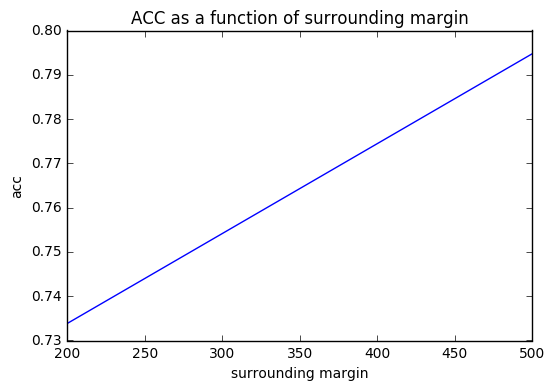

In [25]:
plt.plot(sorted(overall_acc_all_margins.keys()), 
         [overall_acc_all_margins[i] for i in sorted(overall_acc_all_margins.keys())]);
plt.xlabel('surrounding margin');
plt.ylabel('acc');
plt.title('ACC as a function of surrounding margin');

# Compute pairwise accuracy

In [26]:
# Compute pairwise accuracy

n_structures = len(structures_found)
pairwise_cm = np.zeros((n_structures, n_structures))

# for i, label in enumerate(structures):
# axes_id = 0
for i, structure in enumerate(structures_found):
    
#     print i, structure
    
    features_pos = test_features[structure]
    n_pos = len(features_pos)
        
    for j, structure2 in enumerate(structures_found):
        if i > j:
            continue
            
        if i == j:
            pairwise_cm[i,j] = 1
            continue
        
#         print 'comparing with', j, structure2
        
        features_neg = test_features[structure2]
        n_neg = len(features_neg)
        
        test_data = np.r_[features_pos, features_neg]
        test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                             -np.ones((features_neg.shape[0], ))]

        clf = clf_allClasses[structure]

        probs = clf.predict_proba(test_data)[:, clf.classes_.tolist().index(1.)]
        cm_sub = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True,
                                         normalize=False)
        
#         acc = .5 * (cm_sub[0,0] + cm_sub[1,1])
        acc = (cm_sub[0,0] + cm_sub[1,1]) / (n_pos + n_neg)
        pairwise_cm[i,j] = acc
#         cm[j,i] = acc
        
#         r = np.array([i,j])
#         cm[r, r[:,None]] = acc
        
#         plot_confusion_matrix(cm_sub, title='%(label)s vs. %(label2)s'% {'label':label, 'label2':label2},
#                           labels=['',''],
# #                           labels=[label, convert_to_surround_name(label)],
#                          axis=axes[axes_id])
        
#         axes_id += 1

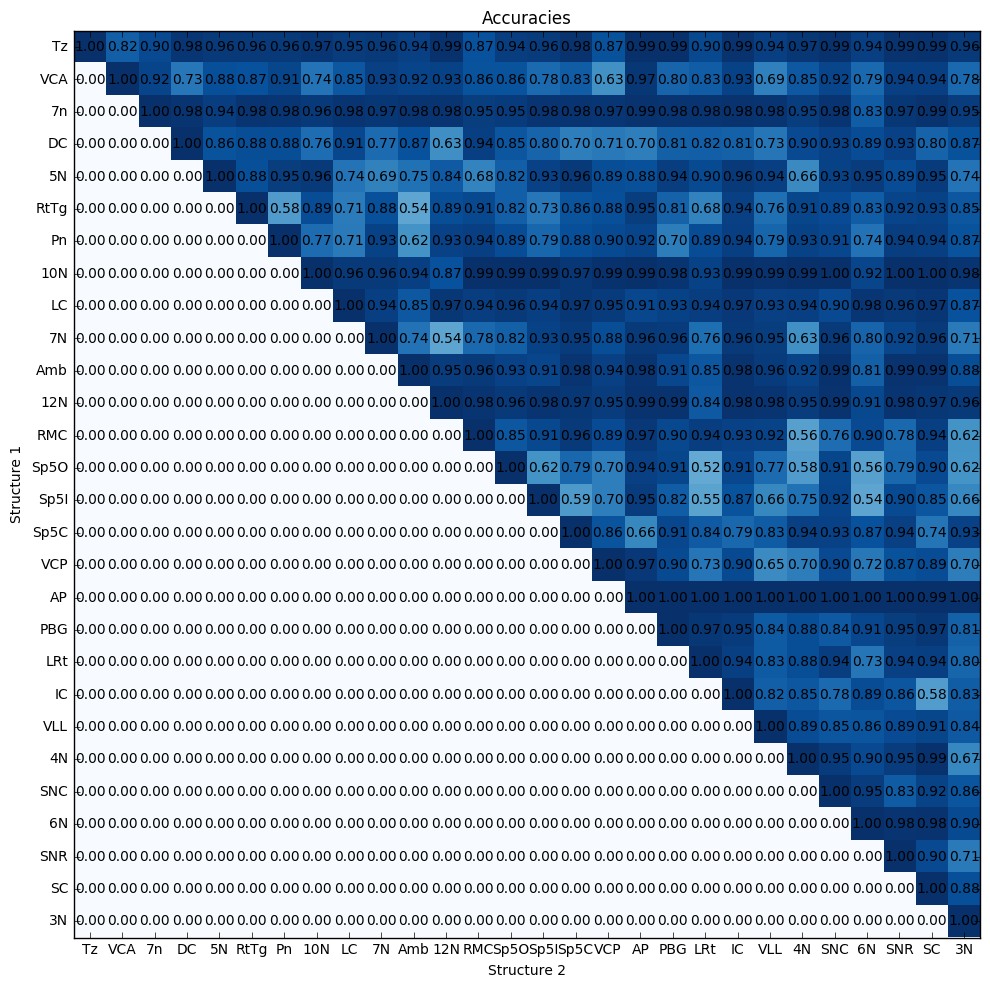

In [27]:
fig = plot_confusion_matrix(pairwise_cm, title='Accuracies',
                      labels=structures_found,
                     figsize=(10,10),
                           xlabel='Structure 2',
                           ylabel='Structure 1')

plt.tight_layout()

In [28]:
pariwise_cm_plot_fp = os.path.join(eval_dir, 'pairwise_cm_setting_%d.png' % setting)
fig.savefig(pariwise_cm_plot_fp, bbox_inches='tight')